# Project Template: Phase 2

Below are some concrete steps that you can take while doing your analysis for phase3. This guide isn't "one size fit all" so you will probably not do everything listed. But it still serves as a good "pipeline" for how to do data analysis.

If you do engage in a step, you should clearly mention it in the notebook.

---


## 2.0) Export and Import your data

Since your existing work is in another notebook, you have a few choices:
1. Export the relevant dataframes (with the preprocessing you want to keep) and re-import it here. **Note**: Many pre-processing steps should not be performed prior to the train/test split (see section 2.3), so you may not need to export all the change.
2. Continue to work in your first notebook, and copy the relevant template code from this notebook.
3. Copy over the most relevant code from your 1st notebook here, and just use the knowledge you've gained from EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import json
import glob
import os
import warnings
warnings.filterwarnings('ignore')


from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import math
import random
from random import randrange
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Import the transformed train and test datasets
train = pd.read_csv("transformed_train.csv")
test = pd.read_csv("transformed_test.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'transformed_test.csv'

## 2.1) Decide on what models you will use and compare

Select at least 3 models to compare on your prediction task. At least 2 of your models should be ones we've covered in class. 

Some resources try to help you select a well-performing model for your data:
* [sklearn's Flowchart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* [geeks4geeks Flowchart](https://www.geeksforgeeks.org/flowchart-for-basic-machine-learning-models/)
* [SAS Cheatsheet](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet.png)

**Note**: These are general guides, and not guarantees of success. Some of the models are also outside of what we have covered, but you can explore them if you want to.

In addition to selecting a model you think will perform well, there are other reasons to select a model:
* To serve as a baseline (naive) approach you expect to outperform with more complex/appropriate models.
* You need a model that is human interpretable (e.g. Decision Tree).
* The model has historically performed well on similar tasks.
* Some properties of the model are effective for the type of data you have. Remember, at the end of most Seminars, you learned the strengths and weaknesses of each model.

1. Model **Decision Tree**: We are selecting Decision Tree because we want to have a human interpretable model that we can analyze ourselves.
2. Model **KNN**: We are selecting KNN because k-nearest neighbors is a powerful supervised learning model which should be able to classify complex patterns.
3. Model **SVM**: We are selecting SVM because support vector machines are less computationally expensive than KNN but should still be powerful in the event than ECONet is too large for KNN.

## 2.2) Split into train and test
Make sure to split your data *before* you apply any transformations.

**Note**: If you have multiple records from the same object (e.g., multiple attempts from the same student), these should all go in either training or test, but not split between them. See the examples for how to accomplish this, and use the [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) class to make it work.

In [47]:
random_seed = 21312434
np.random.seed(random_seed)
X_train, X_test, Y_train, Y_test = train_test_split( train.drop("target", axis=1), train["target"], test_size=0.5, random_state=random_seed)




# Actual
#X_train = train.drop("target", axis=1)
#Y_train = train["target"]
#X_test = test


### 2.2.1) Sampling (If needed)

If one of your classes is very underrepresented (e.g. 1000 of Class 0; 200 of Class 1), you might consider oversampling the minority class (e.g. sample 1000 times with replacement from 200 instances), or undersampling the majority class (e.g. sample 200 times from 1000 instances).

Check out [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) for how to sample a vector.

**Note 1**: You should only ever sample the *training dataset*, never the test. After all, you can't chose the class distribution of your test data!

**Note 2**: Sampling can help a classifier perform better on the minority class, often at the cost of *overall* performance. But this is no guarantee. If you chose to sample, you should compare your classifiers' performance with and without sampling to see if it actually helped.

**Note 3**: Make sure you sample the *same* indices from your training and test data -- otherwise they won't match anymore!


Play around with sampling below (or skip this step if you don't need sampling).

In [48]:
# Generalized SMOTE algorithm as defined by Chawla et al. in the report "SMOTE: Synthetic Minority Over-sampling Technique".
# https://arxiv.org/pdf/1106.1813.pdf

def SMOTE(minority_df, smote_percent, k):
    """
    Input:  minority_df   - dataframe consisting ONLY of minority class samples
            smote_percent - percent of samples to SMOTE as a decimal
            k             - number of nearest neighbors to use for SMOTE
    Output: array of synthetic minority class samples of size floor( minority_df.length * smote_percent )
    """
    
    # Number of objects (rows) in minority_df
    obj_count = minority_df.shape[0]
    # Number of attributes (columns) in minority_df
    attr_count = minority_df.shape[1]
    # Keeps count of number of synthetic samples generated
    synth_count = 0
    
    # If smote_percent is less than 100% (1), shuffle minority_df's rows because only some objects will be sampled
    if smote_percent < 1:
        # This code shuffles the dataframe's rows in-place and resets the indices 
        minority_df = minority_df.sample(frac=1).reset_index(drop=True)
        # Set number of objects to SMOTE
        obj_count = math.floor(obj_count * smote_percent)
        # Set smote_percent to 100% 
        smote_percent = 1
        
    # Else smote_percent is assumed to be in multiples of 100%
    smote_percent = math.floor( smote_percent )
    
    # List of synthetic samples to output, will be converted to dataframe before output
    synth_list = [[0 for x in range(attr_count)] for y in range(obj_count*smote_percent)] 

    # Inner function to generate the synthetic samples
    def Populate(smote_percent, i, nnarray):
        nonlocal synth_count
        while smote_percent != 0:
            # Choose a random number between 0 and k-1 and assign it to nn.
            # This chooses on of the KNNs of i
            nn = randrange(k)
            new_nnarray = nnarray[0]
            # Create the synthetic attributes
            for attr in range(attr_count):      
                dif = minority_df.iloc[new_nnarray[nn], attr] - minority_df.iloc[i, attr]
                gap = random.random() 
                synth_list[synth_count][attr] = minority_df.iloc[i, attr] + gap * dif
            synth_count += 1
            smote_percent -= 1
        return 
    
    # Compute the KNNs for each of minority_df's samples and use them to populate synth_list
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(minority_df)
    for i in range(obj_count):
        # List of i's KNNs as indices
        nnarray = neigh.kneighbors([minority_df.iloc[i].values.flatten().tolist()], return_distance=False)
        # Populate the list of synthetic samples
        Populate(smote_percent, i, nnarray)
    
    # Return the dataframe of synthetic samples
    
    return pd.DataFrame(synth_list, columns = minority_df.columns.values.tolist())

### Testing Smote

In [49]:
data = {'x_val':[455, 455, 45, 950],
        'y_val':[99, 98, 95, 90]}

data_df = pd.DataFrame(data)
data_df

,x_val,y_val
0,455,99
1,455,98
2,45,95
3,950,90


In [50]:
synthetic_df = SMOTE(data_df, 4, 2)
synthetic_df

,x_val,y_val
0,455.000000,99.000000
1,455.000000,99.000000
2,455.000000,98.355297
3,455.000000,98.868250
4,455.000000,98.208068
5,455.000000,98.000000
6,455.000000,98.000000
7,455.000000,98.000000
8,45.000000,95.000000
9,45.000000,95.000000


In [51]:
# Evenly distributed dataset
data =  np.random.randint(1, 5000, size=(200, 2))
df = pd.DataFrame(data, columns = ['Attr1', 'Attr2'])

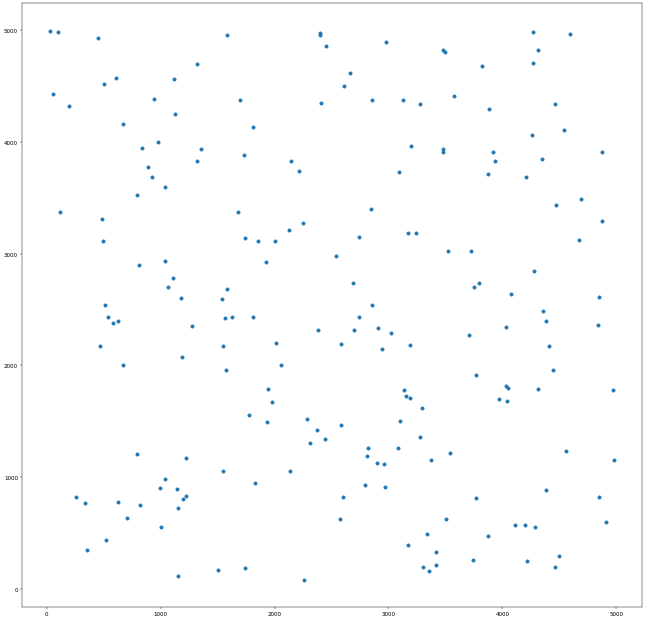

In [52]:
# Plot the data
figure(figsize=(20, 20), dpi=40)
plt.scatter(df['Attr1'], df['Attr2'])
plt.show()

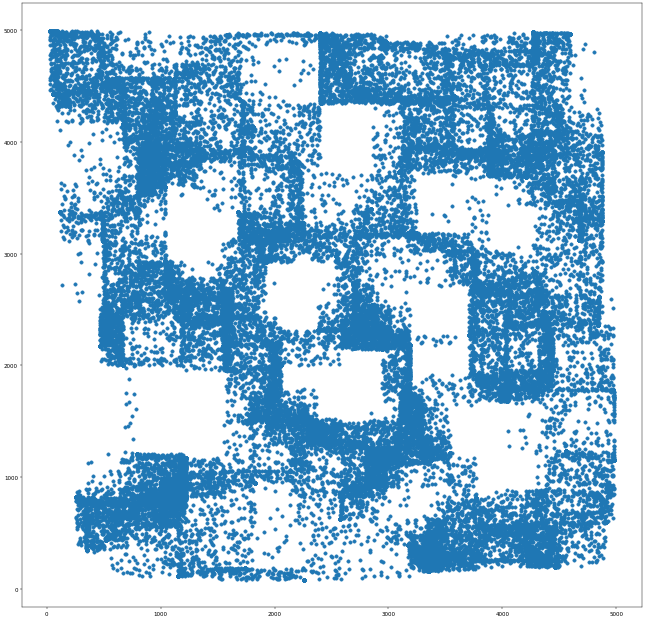

In [53]:
# Plot of SMOTE'd data. Note how the gaps match those of the original points
synthetic_df = SMOTE(df, 200, 10)
figure(figsize=(20, 20), dpi=40)
plt.scatter(synthetic_df['Attr1'], synthetic_df['Attr2'])
plt.show()

In [54]:
# Split dataset
# This makes it a bit easier to see the SMOTE algorithm in action
data1 = np.random.randint(1, 3000, size=(100, 2))
df1 = pd.DataFrame(data1, columns = ['Attr1', 'Attr2'])
data2 = np.random.randint(6000, 9000, size=(100, 2))
df2 = pd.DataFrame(data2, columns = ['Attr1', 'Attr2'])

frames = [df1,df2]
df = pd.concat(frames)

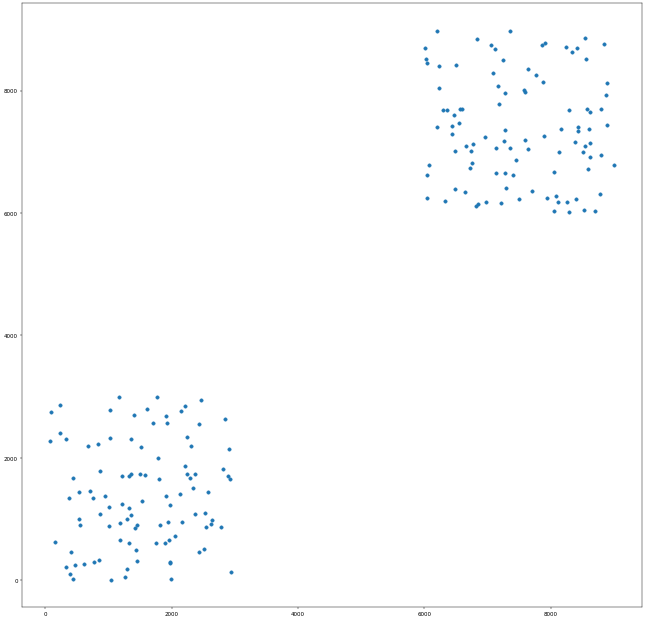

In [55]:
# Initial data before smote
figure(figsize=(20, 20), dpi=40)
plt.scatter(df['Attr1'], df['Attr2'])
plt.show()

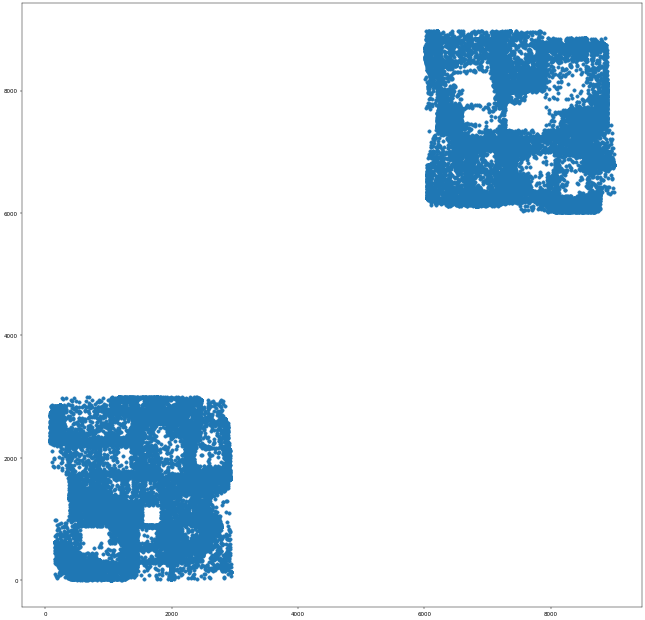

In [56]:
# Plot of SMOTE'd data, note how the new points stay within the split
synthetic_df = SMOTE(df, 200, 10)
figure(figsize=(20, 20), dpi= 40)
plt.scatter(synthetic_df['Attr1'], synthetic_df['Attr2'])
plt.show()

In [57]:
# Specialized SMOTE function to apply to the ECONet dataset that
# automatically performs smote and manages the "Station" and "measure" data

# This version preserves the correlation between 'station' and 'measure'
# by taking combinations of 'station'-'measure' features

def ECONet_SMOTE_Preserve(X_train, Y_train, smote_percent, k ):
    """
    Input: The original X_train and Y_train training dataset
           smote_percent - percent of samples to SMOTE as a decimal
           k             - number of nearest neighbors to use for SMOTE
    Output: A new training dataset with sampling applied (same columns, different rows)
    """
    
    # First, copy the dataframes so they are not modified in place
    X_train, Y_train = X_train.copy("deep=True"), Y_train.copy("deep=True")
    
    # Now add Y back to X to more easily get the minority class
    df = pd.concat([X_train, Y_train], axis=1)
    
    # Get a new dataframe that has only the minority class
    minority_df = df[df["target"] == True]
    
    # Now remove the "target" row from the minority dataframe, it is useless now that all rows are "True"
    minority_df = minority_df[["Station", "Ob", "value", "measure", "R_flag", "I_flag","Z_flag", "B_flag"]]
    
    # Now, loop through every Station/measure combination to produce synthetic dataframes for each individually
    # then merge them together into one big synthetic dataframe. This is necessary because SMOTE does not work
    # with categorical variables like Station and measure
    
    # Big synthetic dataframe to output
    # TODO update this to list to increase performance
    synthetic_df = []
    
    # List of unique "Station" values in the dataframe
    station_values = minority_df["Station"].unique()
    # List of unique "measure" values in the dataframe
    measure_values = minority_df["measure"].unique()
    
    # Loop through each combination of these
    for station in station_values:
        for measure in measure_values:
            # Get a sub-dataframe that has a combination of these values
            sub_df = minority_df[(minority_df["Station"] == station) & (minority_df["measure"] == measure)]
            
            # Continue thorugh the loop if this dataframe has no rows
            if sub_df.shape[0] == 0:
                continue
            
            # Remove the "Station" and "measure" attributes from the dataframe so we can SMOTE it
            sub_df = sub_df[["Ob", "value", "R_flag", "I_flag","Z_flag", "B_flag"]]
            
            # If k is greater than the number of rows in df, set it to number of rows in df
            # TODO Fix this? Explain?
            if(k > sub_df.shape[0]):
                k_new = sub_df.shape[0]
            else:
                k_new = k

            # Smote the dataframe to get synthetic samples that resemble this combination    
            synthetic_sub_df = SMOTE(sub_df, smote_percent, k_new)
            
            # Add the "Station" and "measure" attributes back to the dataframe
            synthetic_sub_df.insert(0, 'Station', station)
            synthetic_sub_df.insert(3, 'measure', measure)
            
            # Round the flag values so they are discrete. 
            # TODO This approach should be updated but its fine for now
            synthetic_sub_df['R_flag'] = synthetic_sub_df['R_flag'].map(round)
            synthetic_sub_df['I_flag'] = synthetic_sub_df['I_flag'].map(round)
            synthetic_sub_df['Z_flag'] = synthetic_sub_df['Z_flag'].map(round)
            synthetic_sub_df['B_flag'] = synthetic_sub_df['B_flag'].map(round)
            
            # Finally, add this new synthetic sub-dataframe to the main synthetic dataframe to output
            synthetic_df.extend(synthetic_sub_df.values.tolist())
            
    # Now, add "target" column to the synthetic dataframe before output
    synthetic_df = pd.DataFrame(synthetic_df, columns = X_train.columns.values.tolist())
    synthetic_df.insert(4, 'target', True)
    
    # Output the new synthetic dataframe
    return (synthetic_df.sort_values("Station")).reset_index(drop=True)

In [58]:
# Specialized SMOTE function to apply to the ECONet dataset that
# automatically performs smote and manages the "Station" and "measure" data

# This version ignores the "station"-"measure" correlation. Only works for smote_percent >= 1

def ECONet_SMOTE_NoPreserve(X_train, Y_train, smote_percent, k ):
    """
    Input: The original X_train and Y_train training dataset
           smote_percent - percent of samples to SMOTE as a decimal
           k             - number of nearest neighbors to use for SMOTE
    Output: A new training dataset with sampling applied (same columns, different rows)
    """
    
    # First, copy the dataframes so they are not modified in place
    X_train, Y_train = X_train.copy("deep=True"), Y_train.copy("deep=True")
    
    # Now add Y back to X to more easily get the minority class
    df = pd.concat([X_train, Y_train], axis=1)
    
    # Get a new dataframe that has only the minority class
    minority_df = df[df["target"] == True]
    
    # Now remove the "target" row from the minority dataframe, it is useless now that all rows are "True"
    minority_df = minority_df[["Station", "Ob", "value", "measure", "R_flag", "I_flag","Z_flag", "B_flag"]]
    
    # Now, loop through every measure to produce synthetic dataframes for each
    # then merge them together into one big synthetic dataframe. This is necessary because SMOTE does not work
    # with categorical variables like measure
    
    # Big synthetic dataframe to output
    synthetic_df = []
    
    # List of unique "measure" values in the dataframe
    measure_values = minority_df["measure"].unique()
    
    # Loop through each measure
    for measure in measure_values:
        # Get a sub-dataframe that has just this measure 
        sub_df = minority_df[minority_df["measure"] == measure]

        # Continue thorugh the loop if this dataframe has no rows
        if sub_df.shape[0] == 0:
            continue

        # Remove the "measure" attributes from the dataframe so we can SMOTE it
        sub_df = sub_df[["Station", "Ob", "value", "R_flag", "I_flag","Z_flag", "B_flag"]]
        
        # Get the "Station" column and drop it from the sub-dataframe
        stations = sub_df["Station"]
        sub_df = sub_df[["Ob", "value", "R_flag", "I_flag","Z_flag", "B_flag"]]
        
        # Update "Station" column by multiplying column by smote_percent
        stations = stations.loc[stations.index.repeat(smote_percent)].reset_index(drop=True)

        # If k is greater than the number of rows in df, set it to number of rows in df
        # TODO Fix this? Explain?
        if(k > sub_df.shape[0]):
            k_new = sub_df.shape[0]
        else:
            k_new = k

        # Smote the dataframe to get synthetic samples that resemble this combination    
        synthetic_sub_df = SMOTE(sub_df, smote_percent, k_new)

        # Add the "Station" and "measure" attributes back to the dataframe
        synthetic_sub_df.insert(0, 'Station', stations)
        synthetic_sub_df.insert(3, 'measure', measure)

        # Round the flag values so they are discrete. 
        # TODO This approach should be updated but its fine for now
        synthetic_sub_df['R_flag'] = synthetic_sub_df['R_flag'].map(round)
        synthetic_sub_df['I_flag'] = synthetic_sub_df['I_flag'].map(round)
        synthetic_sub_df['Z_flag'] = synthetic_sub_df['Z_flag'].map(round)
        synthetic_sub_df['B_flag'] = synthetic_sub_df['B_flag'].map(round)

        # Finally, add this new synthetic sub-dataframe to the main synthetic dataframe to output
        synthetic_df.extend(synthetic_sub_df.values.tolist())
            
    # Now, add "target" column to the synthetic dataframe before output
    synthetic_df = pd.DataFrame(synthetic_df, columns = X_train.columns.values.tolist())
    synthetic_df.insert(4, 'target', True)
    
    # Output the new synthetic dataframe
    return (synthetic_df.sort_values("Station")).reset_index(drop=True)

 When you're done, write the `sample_data` method to perform sampling on any training dataset.

In [59]:
def sample_data_preserve(X_train, Y_train, smote_percent, k):
    """
    Input: The original X_train and Y_train training dataset
    Output: A new training dataset with sampling applied (same columns, different rows)
    """
    # For example, undersample the majority class, or oversample the minority class.
    synth_df = ECONet_SMOTE_Preserve(X_train, Y_train, smote_percent, k)
    
    # Split the synthetic dataframe into X and Y
    synth_df_copy = synth_df.copy("deep=True")

    X_synth_train, Y_synth_train = synth_df_copy.drop("target", axis=1), synth_df_copy["target"]

    # Combine the synthetic set with the original training set
    X_train_copy, Y_train_copy = X_train.copy("deep=True"), Y_train.copy("deep=True")

    X_train_copy, Y_train_copy = pd.concat([X_train_copy, X_synth_train], ignore_index=True), pd.concat([Y_train_copy, Y_synth_train], ignore_index=True)
    
    return (X_train_copy, Y_train_copy)

In [60]:
def sample_data_nopreserve(X_train, Y_train, smote_percent, k):
    """
    Input: The original X_train and Y_train training dataset
    Output: A new training dataset with sampling applied (same columns, different rows)
    """
    # For example, undersample the majority class, or oversample the minority class.
    synth_df = ECONet_SMOTE_NoPreserve(X_train, Y_train, smote_percent, k)
    
    # Split the synthetic dataframe into X and Y
    synth_df_copy = synth_df.copy("deep=True")

    X_synth_train, Y_synth_train = synth_df_copy.drop("target", axis=1), synth_df_copy["target"]

    # Combine the synthetic set with the original training set
    X_train_copy, Y_train_copy = X_train.copy("deep=True"), Y_train.copy("deep=True")

    X_train_copy, Y_train_copy = pd.concat([X_train_copy, X_synth_train], ignore_index=True), pd.concat([Y_train_copy, Y_synth_train], ignore_index=True)
    
    return (X_train_copy, Y_train_copy)

# 2.3) Feature Transformation

Use your training data to fit any transformers or encoder your need, then apply the fit transformer to your test data. This applies to:
* Normalizing/standardizing your features
* Using Bag of Words or TF-IDF to encode strings
* PCA or dimensionality reduction

**Rationale**: In practice, we won't be able to see the test data we'll be making predicting for, so we shouldn't use that data as the basis for any transformation or feature extractio.

Try your feature transformation below:

In [3]:
# Categorical Encoding
test_data1 = pd.Series(['AURO', 'REED', 'REED', 'WINE', 'JACK', 'GOLD', 'AURO', 'GOLD'], dtype="category")
test_data2 = pd.Series(['EXTR', 'JUNK', 'WINE', 'JACK', 'GOLD', 'AURO', 'GOLD'], dtype="category")
categories = ['JUNK', 'EXTR', 'AURO', 'REED', 'WINE', 'JACK', 'GOLD']
test_data1 = test_data1.astype('category').cat.set_categories(categories)
test_data1 = test_data1.astype('category').cat.codes
test_data2 = test_data2.astype('category').cat.set_categories(categories)
test_data2 = test_data2.astype('category').cat.codes
print(test_data1)
print(test_data2)

0    2
1    3
2    3
3    4
4    5
5    6
6    2
7    6
dtype: int8
0    1
1    0
2    4
3    5
4    6
5    2
6    6
dtype: int8


In [4]:
# Testing how it handles dataframes with unique categories
trainVerification = pd.read_csv("ECONet/train.csv")
testVerification = pd.read_csv("ECONet/test.csv")
categories = ['temp_wxt', 'temp_hmp', 'rh_wxt', 'rh_hmp', 'ws10', 'wd10', 'gust10', 'precip', 'impact',
                   'pres', 'par', 'sr', 'st', 'sm', 'temp10', 'ws02', 'wd02', 'gust02', 'ws06', 'wd06', 'gust06',
                   'leafwetness', 'blackglobetemp']
trainVerification['measure'] = trainVerification['measure'].astype('category').cat.set_categories(categories)
trainVerification['measure_code'] = trainVerification['measure'].astype('category').cat.codes
testVerification['measure'] = testVerification['measure'].astype('category').cat.set_categories(categories)
testVerification['measure_code'] = testVerification['measure'].astype('category').cat.codes
print(trainVerification['measure_code'].value_counts() )
print(testVerification['measure_code'].value_counts() )
print(trainVerification)
print(testVerification)

13    3794242
14     751136
11     540212
10     505886
15     503566
18     170547
0      124538
9       75281
2       62329
22      45756
12       7588
4        6997
7        2859
3        1340
21        995
8           2
Name: measure_code, dtype: int64
13    1072005
14     198963
11     161240
15     156674
10     154836
18      45311
0       23983
9       22015
2        9856
22       5563
4        2879
12       2035
21        394
7         323
3          14
8           5
17          4
6           3
16          2
5           1
Name: measure_code, dtype: int64
        Station              Ob   value         measure  target  R_flag  \
0          AURO   1/2/2021 0:30  19.200        temp_wxt   False       2   
1          AURO   1/2/2021 4:30  19.800        temp_wxt   False       2   
2          AURO   1/2/2021 5:30  19.500        temp_wxt   False       2   
3          AURO   1/2/2021 7:30  18.500        temp_wxt   False       2   
4          AURO  2/16/2021 2:30  17.700        temp_wxt

In [5]:
# One Hot Encoding (Harder to use but OneHotEncoder should increase performance)
test_data = np.array(['AURO', 'REED', 'REED', 'WINE', 'JACK', 'GOLD', 'AURO', 'GOLD'])
categories = ['AURO', 'ADDT', 'REED', 'WINE', 'FAKE', 'JACK', 'GOLD']
encoder = LabelEncoder().fit(categories)
test_data = encoder.transform(test_data)
test_data

array([1, 5, 5, 6, 4, 3, 1, 3])

In [6]:
# One Hot Encoding (Harder to use but OneHotEncoder should increase performance)
test_data = np.array(['AURO', 'REED', 'REED', 'WINE', 'JACK', 'GOLD', 'AURO', 'GOLD'])
categories = [['AURO', 'ADDT', 'REED', 'WINE', 'FAKE', 'JACK', 'GOLD']]
encoder = OneHotEncoder(categories=categories, sparse=False, handle_unknown='ignore')
test_data = encoder.fit_transform(test_data.reshape(-1, 1))
test_data

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

 When you're done, write the `apply_feature_transformation` method to perform transformation on any training/test split.

In [65]:
def apply_feature_transformation(X_train, X_test):
    """
    Input: The original X_train and X_test feature sets.
    Output: The transformed X_train and X_test feature sets.
    """
    catStation = ['AURO', 'BAHA', 'BALD', 'BEAR', 'BUCK', 'BURN', 'CAST', 'CHAP', 'CLA2', 'CLAY', 'CLIN', 'DURH', 
                  'FLET', 'FRYI', 'GOLD', 'HAML', 'JACK', 'JEFF', 'KINS', 'LAKE', 'LAUR', 'LEWS', 'LILE', 'MITC', 
                  'NCAT', 'NEWL', 'OXFO', 'PLYM', 'REED', 'REID', 'ROCK', 'SALI', 'SASS', 'SILR', 'SPIN', 'SPRU', 
                  'TAYL', 'UNCA', 'WAYN', 'WHIT', 'WILD', 'WILL', 'WINE']
    
    catMeasure = ['temp_wxt', 'temp_hmp', 'rh_wxt', 'rh_hmp', 'ws10', 'wd10', 'gust10', 'precip', 'impact',
                   'pres', 'par', 'sr', 'st', 'sm', 'temp10', 'ws02', 'wd02', 'gust02', 'ws06', 'wd06', 'gust06',
                   'leafwetness', 'blackglobetemp']
    
    X_train['Station'] = X_train['Station'].astype('category').cat.set_categories(catStation)
    X_train['Station'] = X_train['Station'].astype('category').cat.codes
    X_train['measure'] = X_train['measure'].astype('category').cat.set_categories(catMeasure)
    X_train['measure'] = X_train['measure'].astype('category').cat.codes

    X_test['Station'] = X_test['Station'].astype('category').cat.set_categories(catStation)
    X_test['Station'] = X_test['Station'].astype('category').cat.codes
    X_test['measure'] = X_test['measure'].astype('category').cat.set_categories(catMeasure)
    X_test['measure'] = X_test['measure'].astype('category').cat.codes
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return (X_train, X_test)

## 2.4) Train and Explore your Models
Using the models you decided upon in the beginning, now train these models. Conduct preliminary evaluations to see if using said models are even feasible, before potentially wasting time tuning a model thats no-good.

In [66]:
X_train_smoted, Y_train_smoted = sample_data_nopreserve(X_train, Y_train, 30, 4)
X_train_smoted.to_csv('X_train_smoted1.csv', index=False)
Y_train_smoted.to_csv('Y_train_smoted1.csv', index=False)

In [67]:
# Perform one-hot encoding on the station feature
X_train_smoted, X_test = apply_feature_transformation(X_train_smoted, X_test)

In [68]:
# Model 1: Decision Tree
model1 = DecisionTreeClassifier(criterion="entropy").fit(X_train_smoted, Y_train_smoted)
predictions1 = model1.predict(X_test)
print(classification_report(Y_test, predictions1))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00   3178968
        True       0.98      0.99      0.99    117669

    accuracy                           1.00   3296637
   macro avg       0.99      1.00      0.99   3296637
weighted avg       1.00      1.00      1.00   3296637



In [69]:
# Model 2: K-Nearest Neighbors (KNN)
model2 = KNeighborsClassifier(n_neighbors=2, weights="distance", algorithm="auto", p=1).fit(X_train_smoted, Y_train_smoted)
predictions2 = model2.predict(X_test)
print(classification_report(Y_test, predictions2))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00   3178968
        True       0.94      0.99      0.97    117669

    accuracy                           1.00   3296637
   macro avg       0.97      0.99      0.98   3296637
weighted avg       1.00      1.00      1.00   3296637



In [ ]:
# Model 3: Support Vector Machine (SVM)
model3 = SVC(max_iter=70).fit(X_train_smoted, Y_train_smoted)
predictions3 = model3.predict(X_test)
print(classification_report(Y_test, predictions3))

In [ ]:
# Model 0: Decision Tree on real test
model1 = DecisionTreeClassifier(criterion="entropy", max_depth=30).fit(X_train_smoted, Y_train_smoted)
test_pred = model1.predict_proba(X_test)
pd.DataFrame(test_pred[:,1], columns=['target']).to_csv('predictions.csv', index=False)

## 2.5) Hyperparameter Tuning
For promising models, tune them even further to squeeze out the best possible performance. Some questions to consider.

1. What hyperparamaters should I tune? Why?
2. What values ranges should I choose for each param? Why?
3. Should I use try the values manually, or use the [built-in tuning functions](https://scikit-learn.org/stable/modules/grid_search.html)?

**Make sure to only tune on the training dataset!**

In [36]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters_m1(X_train, Y_train):
    """
    Input: The training X features and Y labels/values
    Output: The classifier with the best hyperparams and the predictions
    """
    clf = DecisionTreeClassifier.fit(X=X_train, y=Y_train) # Create your base classifier
    param_grid = [{"criterion": ["gini", "entropy"],
                   "max_depth": [3, 5],
                   "min_impurity_decrease": [0, 0.05]
    }]
    
    search = GridSearchCV(clf, param_grid, cv=2)
    search.fit(X_train,Y_train)
    return search, search.predict(X_test)

In [37]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters_m2(X_train, Y_train):
    """
    Input: The training X features and Y labels/values
    Output: The classifier with the best hyperparams and the predictions
    """
    clf = KNeighborsClassifier.fit(X_train, Y_train) # Create your base classifier
    param_grid = [{"n_neighbors": [1, 3, 5],
    }]
    
    search = GridSearchCV(clf, param_grid, cv=2)
    search.fit(X_train,Y_train)
    return search, search.predict(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters_m3(X_train, Y_train):
    """
    Input: The training X features and Y labels/values
    Output: The classifier with the best hyperparams and the predictions
    """
    clf = SVC().fit(X_train, Y_train) # Create your base classifier
    param_grid = [{
        "kernel":["linear", "poly", "rbf", "sigmoid"],
        "C":[3, 5],
        "coef0":[0.02, 2],
        "degree": [2], 
        "gamma":[0.01, 0.1],
        "max_iter": 1
    }]
    
    search = GridSearchCV(clf, param_grid, cv=2)
    search.fit(X_train,Y_train)
    return search, search.predict(X_test)

## Put it All Together

Now, combine the "scratch work" that you did above into a tidy function that someone could use to replicate your work and process in a single step.

In [39]:
def evaluate_model1(X_train, X_test, Y_train, Y_test):
    (X_train, Y_train) = sample_data(X_train, Y_train)
    (X_train, X_test) = apply_feature_transformation(X_train, X_test) 
    model, predictions = find_best_hyperparameters_m1(X_train, Y_train)
    # Fit your model here
    
    # Return your model's predictions
    return model, predictions

In [40]:
def evaluate_model2(X_train, X_test, Y_train, Y_test):
    (X_train, Y_train) = sample_data(X_train, Y_train)
    (X_train, X_test) = apply_feature_transformation(X_train, X_test) 
    # You need to create a new hyperparameter selector for your second model, or remove this step
    model, predictions = find_best_hyperparameters_m2(X_train, Y_train)
    # Fit your model here
    
    # Return your model's predictions
    return model, predictions

In [44]:
def evaluate_model3(X_train, X_test, Y_train, Y_test):
    (X_train, Y_train) = sample_data(X_train, Y_train)
    (X_train, X_test) = apply_feature_transformation(X_train, X_test) 
    # You need to create a new hyperparameter selector for your second model, or remove this step
    model, predictions = find_best_hyperparameters_m3(X_train, Y_train)
    # Fit your model here

    # Return your model's predictions
    return model, predictions

In [45]:
#TEMP
# X_train, X_test, Y_train, Y_test = train_test_split( train.drop("target", axis=1), train["target"], test_size=0.33, random_state=random_seed)
model, predictions = evaluate_model2(X_train, X_test, Y_train, Y_test)
report = classification_report(Y_test, predictions)
print(model.best_params_)
print(f'CV accuracy for best params: {model.best_score_}')
print(report)

KeyboardInterrupt: 

## Export Dataset to Part 3

In [ ]:
# Export the new SMOTE oversampled dataframe to csv for use in part 3
# Can set SMOTE hyperparameters here
# oversampled_train = ECONet_SMOTE(train.drop("target", axis=1), train["target"], 10, 2)
# oversampled_train.to_csv('oversampled_train.csv', index=False)